In [1]:
from __future__ import print_function
import sys,os,datetime
import cv2 as cv
import cv2 as cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import fbeta_score
import sklearn.metrics as skm
import csv

In [2]:
print('openCV',cv.__version__)
print('numpy',np.__version__)

openCV 3.2.0
numpy 1.13.3


In [3]:
dirTrain1 = '../Data/train/train/level-1'
dirTrain2 = '../Data/train/train/level-2'
dirTrain3 = '../Data/train/train/level-3'
dirTrain  = dirTrain2
dirDev    = '../Data/dev/dev'
dirForSave = '../Work'

In [4]:
shape2D = (416,416)

In [5]:
def NNTrain(dirTrain) :
    listTrain= os.listdir(dirTrain); len(listTrain); listTrain[:12]
    listTrainNN = []
    for ff in listTrain :
        if ff.lower().endswith('.txt') : listTrainNN.append(ff.split('_')[0])
    return(listTrainNN)
listTrainNN = NNTrain(dirTrain)
len(listTrainNN), listTrainNN[:15]

(1495,
 ['1003',
  '1009',
  '100',
  '1012',
  '1018',
  '1021',
  '984',
  '994',
  '995',
  '997',
  '9',
  '952',
  '955',
  '956',
  '959'])

In [6]:
if 1 :
    try : 
        del XX,YY,NN
    except : a=0
    XX = np.load(os.path.join(dirForSave,'train-XX-S6.npy'))
    YY = np.load(os.path.join(dirForSave,'train-YY-S6.npy'))
    NN = np.load(os.path.join(dirForSave,'train-NN-S6.npy'))
    print(datetime.datetime.now(),'Load: ',XX.shape, YY.shape, NN.shape)
    
if 0 :
    print(datetime.datetime.now(),'For:  ')
    iil = []
    for ii in (0,1,2) :
        YY = np.load(os.path.join(dirForSave,'YY-'+str(ii)+'.npy'))
        iil.append(len(YY))
    iis = int(np.array(iil).sum())
    
    NN = np.array(['1234']*iis)
    X1 = np.zeros((iis,)+shape2D+(3,),dtype=np.float32)
    X2 = np.zeros((iis,)+shape2D+(3,),dtype=np.float32)
    YY = np.zeros((iis,)+shape2D+(1,),dtype=np.float32)
    
    iis = 0
    
    for ii in (0,1,2) :

        if 0 :
            TN  = np.load(os.path.join(dirForSave,'NN-'+str(ii)+'S.npy'))
            T1  = np.load(os.path.join(dirForSave,'X1-'+str(ii)+'.npy'))
            T2  = np.load(os.path.join(dirForSave,'X2-'+str(ii)+'.npy'))
            TT  = np.load(os.path.join(dirForSave,'YY-'+str(ii)+'.npy'))
        
        if 1 : # 2018-02-15
            TN  = np.load(os.path.join(dirForSave,'NN-'+str(ii)+'S.npy'))
            T1  = np.load(os.path.join(dirForSave,'X1-'+str(ii)+'S.npy'))
            T2  = np.load(os.path.join(dirForSave,'X2-'+str(ii)+'S.npy'))
            TT  = np.load(os.path.join(dirForSave,'YY-'+str(ii)+'S.npy'))
        
        X1[iis:iis+len(TT)], X2[iis:iis+len(TT)], YY[iis:iis+len(TT)], NN[iis:iis+len(TT)] = T1, T2, TT, TN
        
        iis+= len(TT)
        
        del TT, T1, T2, TN
        
    
    print(datetime.datetime.now(),'Load: ', X1.shape, X2.shape, YY.shape)
    
YY = YY/YY.max()
XX.shape,YY.shape, YY.max()

2018-02-26 14:52:10.762762 Load:  (4119, 416, 416, 6) (4119, 416, 416, 1) (4119,)


((4119, 416, 416, 6), (4119, 416, 416, 1), 1.0)

In [7]:
YY = YY/YY.max()
XX.shape,YY.shape, YY.max()

((4119, 416, 416, 6), (4119, 416, 416, 1), 1.0)

In [8]:
sample_weights = np.ones(len(YY),dtype=np.float32); sample_weights[0]
bad_samples    = ( 340,  491,  817,  937, 1125, 1751, 1858, 2091, 2378, 2385, 3030, 3050, 3326, 
                  3333, 3435, 3761, 3905, 4505, 4620, 4661, 4750, 4839, 5020, 5160, 5425, 5481, 
                  5597, 5607, 6100, 6163, 6349, 6460, 6555, 6578, 6683, 6760, 6877)
for ii,nn in enumerate(NN) :
    if int(nn) in bad_samples : sample_weights[ii] = 0.01
        
sample_weights.min(), sample_weights.max(), len(NN)

(0.0099999998, 1.0, 4119)

In [9]:
from keras.models import Input, Model
from keras.layers import Convolution2D, MaxPooling2D, UpSampling2D, Conv2D, Concatenate, Activation, Dropout,Add
from keras.layers import Conv2DTranspose, SpatialDropout2D, Dense, Reshape, Flatten
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import keras
import keras.backend as K 

Using TensorFlow backend.


In [912]:
#K.clear_session()
import tensorflow as tf

def diceCC (truth, pred_, th=None) : # classic realization = inter/union
    pred = pred_
    if not (th is None) :
        pred = tf.to_float(K.greater(pred_,th))
    g, s = K.sum(truth,axis=(1,2,3)), K.sum(pred,axis=(1,2,3))
    x   = K.sum(truth*pred,axis=(1,2,3))
    dice = K.mean((2.0*x+0.001)/(g+s+0.001),axis=-1)
    return(K.clip(dice, 0.0, 1.0))

def dicePP (truth, pred, th=None, th1=0.55, th1sum=0.1, kernel=5) :
    
    one15  = K.ones((kernel,kernel,1,1))
    one15s = float(kernel*kernel)

    def diceHV(truth,pred,axis=-1) :
        g  = K.conv2d(truth,one15,strides=(1,1),padding='same',dilation_rate=None) #dilation_rate
        s  = K.conv2d(pred ,one15,strides=(1,1),padding='same',dilation_rate=None)
        x  = K.conv2d(truth*pred,one15,strides=(1,1),padding='same',dilation_rate=None)
        diceMean = (2.0*x+0.001)/(g+s+0.001) # /one15s
        
        dd       = K.clip(tf.to_float(K.greater(diceMean,th1))+th1sum,th1sum,1.0)
        diceMean = diceMean*dd
        return (diceMean)
        
    diceMean1 = diceHV(truth,pred)
    
    dice      = K.mean(diceMean1,axis=-1) #dice/(15.0*15.0)
    
    

    
    # ????dd        = K.clip(tf.to_float(K.greater(dice,th1))+th1sum,th1sum,1.0)
    # ????dice      = dice*dd
    
    return(K.clip(dice, 0.0, 1.0))

def dicePP01 (truth, pred, th=0.5) : return(dicePP(truth,pred,th=th))

In [949]:
#K.clear_session()
import tensorflow as tf

#--------------------------------------------------------------------------
def F1ScoreCC (truth, pred_, th=None, printOK=False) : # classic realization
    pred = pred_
    if not (th is None) :
        pred = tf.to_float(K.greater(pred_,th))
        if printOK : print('not None',th)
        
    tp     = K.sum(truth*pred,           axis=(1,2,3))
    fp     = K.sum(K.abs(truth-1.0)*pred,axis=(1,2,3))
    fn     = K.sum(truth*K.abs(pred-1.0),axis=(1,2,3))
    tn     = K.sum(K.abs(truth-1.0)*K.abs(pred-1.0),axis=(1,2,3))
    
    #if (tp+fp)>0.0 :precision = tp/(tp+fp)
    #if (fp+fn)>0.0 : recall    = tp/(fp+fn)
    
    tpfp   = tp+fp
    tpfn   = tp+fn

    kUp       = tf.to_float(K.not_equal(0.0,tpfp))
    kDown     = tf.to_float(K.equal    (0.0,tpfp))
    precision = (tp*kUp)/(K.maximum(tpfp,kDown))

    kUp       = tf.to_float(K.not_equal(0.0,tpfn))
    kDown     = tf.to_float(K.equal    (0.0,tpfn))
    recall    = (tp*kUp)/(K.maximum(tpfn,kDown))

    prre      = precision+recall

    kUp       = tf.to_float(K.not_equal(0.0,prre))
    kDown     = tf.to_float(K.equal    (0.0,prre))
    fscore    = (2.0*precision*recall*kUp)/K.maximum((precision+recall),kDown)
        
    ##dice = K.mean((2.0*x+0.001)/(g+s+0.001),axis=-1)
    
    fzeros    = tf.to_float(K.equal(0.0,tp))*tf.to_float(K.equal(0.0,fp))*tf.to_float(K.equal(0.0,fn))
    fscore    = fscore+fzeros
    
    if printOK : 
        print('tp={0}\nfp={1}\nfn={2}\npr={3}\nre={4}\nf1={5}'.
              format(K.eval(tp),K.eval(fp),K.eval(fn),K.eval(precision),K.eval(recall),K.eval(fscore)))
        
    return(K.clip(fscore, 0.0, 1.0))


def F1ScorePP (truth, pred_, th=0.5, th1=0.5, th1sum=0.1, kernel=3) :
    
    pred = pred_
    if not (th is None) :
        pred = tf.to_float(K.greater(pred_,th))
        
    one15  = K.ones((kernel,kernel,1,1))
    
    if 0 :
        one15  = cv2.getGaussianKernel(kernel,-1)*cv2.getGaussianKernel(kernel,-1).T
        one15  = one15.reshape(one15.shape+(1,1,))
        one15  = K.variable(one15)
        ##print(one15)

    def convHV(truth,pred,axis=-1) :
        #tp     = K.sum(truth*pred,axis=(1,2,3))
        #fp     = K.sum(K.abs(truth-1.0)*pred)
        #fn     = K.sum(K.abs(truth-1.0)*K.abs(pred-1.0))
        
        tp     = K.conv2d(truth*pred,                       one15,strides=(1,1),padding='same',dilation_rate=None)
        fp     = K.conv2d(K.abs(truth-1.0)*pred,            one15,strides=(1,1),padding='same',dilation_rate=None)
        fn     = K.conv2d(truth*K.abs(pred-1.0),            one15,strides=(1,1),padding='same',dilation_rate=None)
        
        #print(K.eval(tp),K.eval(fp),K.eval(fn))
        
        tpfp   = tp+fp
        tpfn   = tp+fn
        
        kUp       = tf.to_float(K.not_equal(0.0,tpfp))
        kDown     = tf.to_float(K.equal    (0.0,tpfp))
        precision = (tp*kUp)/(K.maximum((tp+fp),kDown))
        
        kUp       = tf.to_float(K.not_equal(0.0,tpfn))
        kDown     = tf.to_float(K.equal    (0.0,tpfn))
        recall    = (tp*kUp)/(K.maximum((tp+fn),kDown))
        
        prre      = precision+recall

        kUp       = tf.to_float(K.not_equal(0.0,prre))
        kDown     = tf.to_float(K.equal    (0.0,prre))
        fscore = (2.0*precision*recall*kUp)/K.maximum((precision+recall),kDown)

        fzeros    = tf.to_float(K.equal(0.0,tp))*tf.to_float(K.equal(0.0,fp))*tf.to_float(K.equal(0.0,fn))
        fscore    = fscore+fzeros

        return(K.clip(fscore, 0.0, 1.0))
        
    F1Score = convHV(truth,pred)
    
    #################F1Score+= (truth-1.0)*(pred-1.0) # 0-0 ==> f1==1 around clip 27.02.2018
    F1Score = K.mean(F1Score,axis=-1) 
    
    # ????dd        = K.clip(tf.to_float(K.greater(dice,th1))+th1sum,th1sum,1.0)
    # ????dice      = dice*dd
    
    return(K.clip(F1Score, 0.0, 1.0))


def f1scoreTF (truth, pred, th=0.5, **kwargs) :
    return(F1ScoreCC(truth,pred,th=th, **kwargs))

def f1scoreTF_new_wrong (truth, pred, th=None, **kwargs) :
    return(K.mean(F1ScorePP(truth,pred,th=th, **kwargs)))

def lossXf1 (truth,pred) :
    return(keras.losses.binary_crossentropy(truth,pred) - K.log(F1ScorePP(truth,pred,th=0.5)+1.0))

def lossZf1 (truth,pred) :
    return(keras.losses.binary_crossentropy(truth,pred) - 
           K.log(K.clip(F1ScorePP(truth,pred,th=0.5),K.epsilon(),1.0)))

def lossZf1_old1 (truth,pred) :
    return(2.0*keras.losses.binary_crossentropy(truth,pred) + 1.0*(1.0 - K.mean(F1ScoreCC(truth,pred,th=0.5))))

def lossZf1_old0 (truth,pred) :
    return(4.0*keras.losses.binary_crossentropy(truth,pred) + (1.0 - F1ScorePP(truth,pred,th=None)))

def lossZf1_xxx (truth,pred) :
    return(keras.losses.binary_crossentropy(truth,pred) + 
           4.0*(1.0 - F1ScorePP(truth,pred,th=0.5)) + 
           4.0*dicePP01(truth,pred))

def lossYf1 (truth,pred) :
    #return( - K.log(F1ScoreCC(truth,pred) ))
    return( 1.0 - F1ScorePP(truth,pred))

In [950]:
sys.path.append('../Python')
from LinkNetBoba import LinkNetBoba

In [915]:
#!/usr/local/bin/python
# -*- coding: utf-8 -*-
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#
# model LinkNet realization for Keras (TensorFlow?)
#
# from: https://arxiv.org/pdf/1707.03718.pdf
# 
#   Abhishek Chaurasia, Eugenio Culurciello
#   LinkNet: Exploiting Encoder Representations for Efficient Semantic Segmentation
#
#
#
# realizate by Vladimir Sorokin
#
# For FREE use
#
#
# keys: LinkNet, Keras, Boba
#
# 2017-11-25
#
# 2017-12-11 1. The add operator in blockEncoder move after batch operator and after activation operator
#            2. Add batch operator 2th conv2 in blockEncoder   
#
# 2017-12-15 1. Fix bugs with names layers
#            2. Change last layers
#            3. Add activation parameter for last layer
#            4. Add conv2D before last layer
#
# 2018-02-11
#            1. Fix bugs (acti_last --> acti in pre-last activation)
#            2. Add prefix-name parameter
#
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

from keras.models import Input, Model
from keras.layers import Convolution2D, MaxPooling2D, UpSampling2D, Conv2D, Concatenate, Activation, Dropout,Add
from keras.layers import Conv2DTranspose, SpatialDropout2D
from keras.layers.normalization import BatchNormalization

def LinkNetBoba (img_shape, n_out=1, depth=4, 
                 acti='elu', acti_last='sigmoid', 
                 dropout=False, batch=True, 
                 prefix='boba',printOK=False):
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # Encoder block
    #
    
    def blockEncoder(i, depth, maxDepth, mm, nn) :
        
        io = i
        
        #print('e 0 depth=',depth,io.shape)
        
        io = Conv2D(nn, (3, 3), strides=2, padding='same', name=prefix+"_"+'conv1d'+str(maxDepth-depth))(io)
        if batch : io = BatchNormalization(name=prefix+"_"+'bath1d'+str(maxDepth-depth))(io)
        io = Activation(acti)(io)
        
        #print('e 1 depth=',depth,io.shape)
        
        io = Conv2D(nn, (3, 3), padding='same', name=prefix+"_"+'conv2d'+str(maxDepth-depth))(io)
        if batch : io = BatchNormalization(name=prefix+"_"+'bath2d'+str(maxDepth-depth))(io)
        
        ii = Conv2D(nn, (1, 1), strides=2, name=prefix+"_"+'ii1d'+str(maxDepth-depth))(i)
        if batch : io = BatchNormalization(name=prefix+"_"+'bath3d'+str(maxDepth-depth))(io) # 2017-12-11 add batch
        
        io = Add()([io, ii]); io1 = io;
        
        io = Activation(acti)(io)   # 2017-12-11 change point add before activation after batch
        
        io = Conv2D(nn, (3, 3), padding='same', name=prefix+"_"+'conv3d'+str(maxDepth-depth))(io)
        if batch : io = BatchNormalization(name=prefix+"_"+'bath4d'+str(maxDepth-depth))(io)
        io = Activation(acti)(io)                
        
        io = Conv2D(nn, (3, 3), padding='same', name=prefix+"_"+'conv4d'+str(maxDepth-depth))(io)
        if batch : io = BatchNormalization(name=prefix+"_"+'bath5d'+str(maxDepth-depth))(io)
        
        io = Add()([io, io1]);     # 2017-12-11 change point add before activation after batch
        
        io = Activation(acti)(io)                
        
        ##io = Concatenate()([io, io1]);
        
        return (io)
        

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # Decoder block
    #
    
    def blockDecoder(i, depth, maxDepth, mm, nn) :
        
        io = i
        
        io = Conv2D(mm//4, (1, 1), padding='same', name=prefix+"_"+'convd1d'+str(maxDepth-depth))(io)
        if batch : io = BatchNormalization(name=prefix+"_"+'bathd1d'+str(maxDepth-depth))(io)
        io = Activation(acti)(io)                
        
        io = Conv2DTranspose(mm//4, (3, 3), padding='same', name=prefix+"_"+'convd2d'+str(maxDepth-depth))(io)
        if batch : io = BatchNormalization(name=prefix+"_"+'bathd2d'+str(maxDepth-depth))(io)
        io = Activation(acti)(io)    
        
        io = UpSampling2D((2,2))(io)
        
        io = Conv2D(nn, (1, 1), padding='same', name=prefix+"_"+'convd3d'+str(maxDepth-depth))(io)
        if batch : io = BatchNormalization(name=prefix+"_"+'bathd3d'+str(maxDepth-depth))(io)
        io = Activation(acti)(io)                
        
        return (io)
        

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # Level block (recursive call build levels) 
    #
    
    def blockLevel(i, depth, maxDepth):

        #if batch : m = BatchNormalization(name='bath1d'+str(maxDepth-depth))(m)
        #if batch and depth==maxDepth : m = BatchNormalization(name='bath1d'+str(maxDepth-depth))(m)
        
        if depth == maxDepth : return(i);
        
        emm, enn =  emm0[depth-1],  enn0[depth-1]
        dmm, dnn =  dmm0[depth-1],  dnn0[depth-1]
        
        #print('l 0 depth=',depth,i.shape)
        en  = blockEncoder(i,depth,maxDepth,emm,enn)
        
        #print('l 1 depth=',depth,en.shape)
        le  = blockLevel(en,depth+1,maxDepth)
        
        
        
        if printOK : print('l 2 depth={} en={} le={}'.format(depth,en.shape,le.shape))
        io  = Add()([en, le]);
        #io  = Concatenate()([en, le]);
        de  = blockDecoder(io,depth,maxDepth,dmm,dnn)
        #print('l L depth=',depth,en.shape)
        
        return de
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # Main function block
    #
    
    maxDepth = 4
    depth    = 0
    
    emm0 = [64, 64,128,256]
    enn0 = [64,128,256,512]
    
    ##emm0 = [64, 64,128,256,512]
    ##enn0 = [64,128,256,512,1024]
    
    dmm0 = enn0
    dnn0 = emm0
    
    i = Input(shape=img_shape, name=prefix+"_"+'input'); io = i
    if True : # always exists  
        io = BatchNormalization(name=prefix+"_"+'bath0d'+str(maxDepth-depth))(io)
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # Initial function block
    #
    
    #print(io.shape)

    io = Conv2D(64, (7, 7), strides=2, padding='same', name=prefix+"_"+'conv1d'+str(maxDepth-depth))(io)
    if batch : io = BatchNormalization(name=prefix+"_"+'bath1d'+str(maxDepth-depth))(io)
    io = Activation(acti)(io)                
        
    io = MaxPooling2D((3, 3), strides=2, name=prefix+"_"+'pool1d'+str(maxDepth-depth))(io)
    
    ##print('before',io.shape)
    
    # levels block
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # Main build levels
    #
    
    io = blockLevel(io,depth+1,maxDepth)
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # Final function block
    #

    io = Conv2DTranspose(32, (3, 3), padding='same', name=prefix+"_"+'conv2d'+str(maxDepth-depth))(io)
    if batch : io = BatchNormalization(name=prefix+"_"+'bath2d'+str(maxDepth-depth))(io)
    io = Activation(acti)(io)                
    
    io = UpSampling2D((2,2))(io)
        
    io = Conv2D(32, (3,3), padding='same', name=prefix+"_"+'conv3d'+str(maxDepth-depth))(io)
    if batch : io = BatchNormalization(name=prefix+"_"+'bath3d'+str(maxDepth-depth))(io)
    io = Activation(acti)(io)                
    
    if dropout : io = SpatialDropout2D(rate=dropout, name=prefix+"_"+'dropLd'+str(maxDepth-depth))(io)
        
    ###io = UpSampling2D((2,2))(io) -- ?????? do bad output result 
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # The End. Build output
    #
    
    io = Conv2DTranspose(n_out, (2, 2), strides=2, padding='same', name=prefix+"_"+'conv4d'+str(maxDepth-depth))(io)
    if batch : io = BatchNormalization(name=prefix+"_"+'bath4d'+str(maxDepth-depth))(io)
    io = Activation(acti)(io)                

    io = Conv2D(n_out, (3,3), padding='same', name=prefix+"_"+'conv5d'+str(maxDepth-depth))(io)
    if batch : io = BatchNormalization(name=prefix+"_"+'bath5d'+str(maxDepth-depth))(io)
    io = Activation(acti)(io)

    io = Conv2D(n_out, (1,1), padding='same', name=prefix+"_"+'convLd'+str(maxDepth-depth))(io)
    o = Activation(acti_last)(io)

    return Model(inputs=i, outputs=o, name='LinkNetBoba')

if 0 :

    model10 = LinkNetBoba((512,512,3), n_out=1, dropout=0.20, batch=False, acti='elu')
    model10.summary()


In [916]:
def mergeXX00 (img_shape,n_out=1, acti='elu', dropout=False, batch=True, acti_last='sigmoid') :
    
    i  = Input(shape=img_shape); io = i
    if True : # always exists  
        io = BatchNormalization()(io)
    
    for cc in (64,128) : #128,256) : 

        io = Conv2D(cc, (3,3), padding='same')(io)
        io = Conv2D(cc, (3,3), padding='same')(io)
        io = Conv2D(cc, (3,3), padding='same')(io)
        if batch : io = BatchNormalization()(io)
        io = Activation(acti)(io)
        #io = MaxPooling2D((2,2))(io)

    #io = UpSampling2D((8,8))(io)
    #io = Flatten()(io)
    #io = Dense(416*416)(io)
    #io = Reshape((416,416,1))(io)
    
    io = Conv2D(6, (3,3), padding='same')(io)
    io = Activation(acti)(io)

    o = LinkNetBoba(img_shape,prefix='boba1',n_out=1,acti_last='tanh')(io)

    return Model(inputs=i, outputs=o, name='LinkNet2Boba')

In [917]:
def mergeXX01 (img_shape,n_out=1, acti='elu', dropout=False, batch=True, acti_last='sigmoid') :
    
    i  = Input(shape=img_shape); io = i
    if True : # always exists  
        io = BatchNormalization()(io)
    
    io  = keras.applications.mobilenet.MobileNet(include_top=False, input_shape=(416,416,6), weights=None) (io)
    
    io  = Reshape((416,416,1))(io)
    io  = Conv2D(1, (3,3), padding='same')(io)
    #io = Activation(acti)(io)
    
    o = LinkNetBoba((416,416,1),prefix='boba1',n_out=1,acti_last=acti_last)(io)

    return Model(inputs=i, outputs=o, name='LinkNet2Boba')


In [918]:
from keras.applications.resnet50 import conv_block, identity_block

def mergeXX02R (img_shape,n_out=1, acti='elu', dropout=False, batch=True, acti_last='sigmoid') :
    
    i  = Input(shape=img_shape); io = i
    if True : # always exists  
        io = BatchNormalization()(io)
    
    #io  = keras.applications.resnet50.ResNet50(include_top=False, input_shape=img_shape, weights=None) (io)
    x = Conv2D(64, (7, 7), strides=(2, 2), padding='same', name='conv1')(io)
    x = BatchNormalization(name='bn_conv1')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)

    x = conv_block(x, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1))
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='b')
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='c')

    x = conv_block(x, 3, [128, 128, 512], stage=3, block='a')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='b')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='c')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='d')

    x = conv_block(x, 3, [256, 256, 1024], stage=4, block='a')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='b')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='c')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='d')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='e')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='f')

    
    #x = conv_block(x, 3, [512, 512, 2048], stage=5, block='a')
    #x = identity_block(x, 3, [512, 512, 2048], stage=5, block='b')
    #x = identity_block(x, 3, [512, 512, 2048], stage=5, block='c')
    
    #x = conv_block(x, 3, [512, 512, 2048], stage=6, block='a')
    #x = identity_block(x, 3, [512, 512, 2048], stage=6, block='b')
    #x = identity_block(x, 3, [512, 512, 2048], stage=6, block='c')
    
    x  = Conv2DTranspose(6,kernel_size=(5,5),strides=(16,16))(x)
    x  = Activation(acti)(x)
    
    '''
    x  = UpSampling2D((2,2))(x)
    x  = Conv2D(512, (3,3), padding='same')(x)
    x  = Activation(acti)(x)
    x  = UpSampling2D((2,2))(x)
    x  = Conv2D(256, (3,3), padding='same')(x)
    x  = Activation(acti)(x)
    x  = UpSampling2D((4,4))(x)
    x  = Conv2D(6, (3,3), padding='same')(x)
    x  = Activation(acti)(x)
    '''
    
    return Model(inputs=i, outputs=x)

if 1 :
    xx = mergeXX02R((416,416,6))
    xx.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_4 (InputLayer)             (None, 416, 416, 6)   0                                            
____________________________________________________________________________________________________
batch_normalization_5 (BatchNorm (None, 416, 416, 6)   24          input_4[0][0]                    
____________________________________________________________________________________________________
conv1 (Conv2D)                   (None, 208, 208, 64)  18880       batch_normalization_5[0][0]      
____________________________________________________________________________________________________
bn_conv1 (BatchNormalization)    (None, 208, 208, 64)  256         conv1[0][0]                      
___________________________________________________________________________________________

In [920]:
from keras.applications.resnet50 import conv_block, identity_block

def resnet18 (img_shape,n_out=1, acti='elu', dropout=False, batch=True, acti_last='sigmoid') :
    
    i  = Input(shape=img_shape); io = i
    if True : # always exists  
        io = BatchNormalization()(io)
    
    #io  = keras.applications.resnet50.ResNet50(include_top=False, input_shape=img_shape, weights=None) (io)
    x = Conv2D(64, (7, 7), strides=(2, 2), padding='same', name='conv1')(io)
    x = BatchNormalization(name='bn_conv1')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)

    x = conv_block(x, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1))
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='b')
    #x = identity_block(x, 3, [64, 64, 256], stage=2, block='c')

    x = conv_block(x, 3, [128, 128, 512], stage=3, block='a')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='b')
    #x = identity_block(x, 3, [128, 128, 512], stage=3, block='c')
    #x = identity_block(x, 3, [128, 128, 512], stage=3, block='d')

    x = conv_block(x, 3, [256, 256, 1024], stage=4, block='a')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='b')
    #x = identity_block(x, 3, [256, 256, 1024], stage=4, block='c')
    #x = identity_block(x, 3, [256, 256, 1024], stage=4, block='d')
    #x = identity_block(x, 3, [256, 256, 1024], stage=4, block='e')
    #x = identity_block(x, 3, [256, 256, 1024], stage=4, block='f')


    x = conv_block(x, 3, [512, 512, 2048], stage=5, block='a')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='b')
    #x = identity_block(x, 3, [512, 512, 2048], stage=5, block='c')
    
    # decoder
    
    #######x  = Conv2DTranspose(n_out,kernel_size=(8,8),strides=(8,8))(x)
    #######x  = BatchNormalization()(x)
    #######x  = Activation(acti_last)(x)
    
    
    x  = UpSampling2D((2,2))(x)
    x  = Conv2D(512, (3,3), padding='same')(x)
    x  = UpSampling2D((2,2))(x)
    x  = Conv2D(256, (3,3), padding='same')(x)
    x  = UpSampling2D((2,2))(x)
    x  = Conv2D(128, (3,3), padding='same')(x)
    x  = UpSampling2D((2,2))(x)
    
    x  = Conv2D(64, (3,3), padding='same')(x)
    x  = UpSampling2D((2,2))(x)
    
    x  = Conv2D(n_out, (2,2), padding='same')(x)
    x  = BatchNormalization()(x)
    x  = Activation(acti_last)(x)
    
    return Model(inputs=i, outputs=x)

if 1 :
    xx = resnet18((416,416,6),n_out=6)
    xx.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_6 (InputLayer)             (None, 416, 416, 6)   0                                            
____________________________________________________________________________________________________
batch_normalization_8 (BatchNorm (None, 416, 416, 6)   24          input_6[0][0]                    
____________________________________________________________________________________________________
conv1 (Conv2D)                   (None, 208, 208, 64)  18880       batch_normalization_8[0][0]      
____________________________________________________________________________________________________
bn_conv1 (BatchNormalization)    (None, 208, 208, 64)  256         conv1[0][0]                      
___________________________________________________________________________________________

In [921]:
26*26*1024, 416*416*1

(692224, 173056)

In [922]:
def mergeXX02 (img_shape,n_out=1, acti='elu', dropout=False, batch=True, acti_last='sigmoid') :
    
    img_shape1 = img_shape[:-1]+(1,)
    img_shape3 = img_shape[:-1]+(3,)
    
    i  = Input(shape=img_shape); io = i
    if True : # always exists  
        io = BatchNormalization()(io)
    
    io  = resnet18(img_shape,n_out=6) (io); io1 = io
    #io  = keras.applications.resnet50.ResNet50(include_top=False, input_shape=img_shape, weights=None) (io)
    
    #io  = Reshape((416,416,1))(io)
    #io  = Conv2D(6, (3,3), padding='same')(io)
    #io = Activation(acti)(io)
    
    #i1  = Conv2D(3, (3,3), padding='same')(io)
    
    #io  = Add()([io, i1]);
    
    io = LinkNetBoba(img_shape,prefix='boba1',n_out=1,acti_last=acti_last)(io)
    
    #io  = Add()([io, io1]);

    io  = Conv2D(1, (3,3), padding='same')(io)
    io  = BatchNormalization()(io)
    io  = Activation(acti_last)(io)

    #return Model(inputs=i, outputs=[io,io1], name='LinkNet2Boba')
    return Model(inputs=i, outputs=io, name='LinkNet2Boba')


In [923]:
def mergeXX03 (img_shape,n_out=1, acti='elu', dropout=False, batch=True, acti_last='sigmoid') :
    
    i  = Input(shape=img_shape); io = i
    if True : # always exists  
        io = BatchNormalization()(io)
    
    io = LinkNetBoba(img_shape,prefix='boba1',n_out=6,acti_last=acti_last)(io)

    io  = mergeXX02R(img_shape) (io)
    #io  = keras.applications.resnet50.ResNet50(include_top=False, input_shape=img_shape, weights=None) (io)
    
    io  = Conv2D(1, (3,3), padding='same')(io)
    io = Activation(acti_last)(io)
    
    return Model(inputs=i, outputs=io, name='LinkNet2Boba')


In [1012]:
K.clear_session()
#model10 = LinkNetBoba((416,416,6),prefix='boba1',n_out=1)
#model10 = mergeXX00((416,416,6))
#model10 = mergeXX02((416,416,6))
model10 = mergeXX02((416,416,6))
model10.compile(loss=lossZf1, #'binary_crossentropy',
              optimizer='adam', #sgd, #"adam", #'rmsprop',
              metrics=['binary_accuracy',f1scoreTF]) #['binary_accuracy']) #[fbeta_pred]) #['accuracy',fbeta_pred]) #['accuracy'])
model10.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 416, 416, 6)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 416, 416, 6)       24        
_________________________________________________________________
model_1 (Model)              (None, 416, 416, 6)       24989878  
_________________________________________________________________
LinkNetBoba (Model)          (None, 416, 416, 1)       2915021   
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 416, 416, 1)       10        
_________________________________________________________________
batch_normalization_4 (Batch (None, 416, 416, 1)       4         
_________________________________________________________________
activation_54 (Activation)   (None, 416, 416, 1)       0         
Total para

In [1013]:
model20 = keras.applications.resnet50.ResNet50(include_top=False, input_shape=(416,416,3), weights='imagenet')
model20.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_3 (InputLayer)             (None, 416, 416, 3)   0                                            
____________________________________________________________________________________________________
conv1 (Conv2D)                   (None, 208, 208, 64)  9472        input_3[0][0]                    
____________________________________________________________________________________________________
bn_conv1 (BatchNormalization)    (None, 208, 208, 64)  256         conv1[0][0]                      
____________________________________________________________________________________________________
activation_55 (Activation)       (None, 208, 208, 64)  0           bn_conv1[0][0]                   
___________________________________________________________________________________________

In [1014]:
for mm in model10.layers :
    if mm.name=='model_1' :
        for ll in mm.layers : 
            if ll.name.startswith('res') :
                llww = ll.get_weights()
                #mm20name = model20.layers[ll.name].name
                for ii20,ll20 in enumerate(model20.layers) :
                    if ll20.name==ll.name : break
                if not(ll20.name==ll.name) : ii = -1
                    
                if ii>0 :
                    ll20ww = ll20.get_weights()
                    print(ll.name, ll20.name, [xx.shape for xx in llww])
                    ll.set_weights(ll20ww)
                    if 1 and (ll.name.startswith('res2') or 
                              ll.name.startswith('res3') or
                              ll.name.startswith('res5') or
                              ll.name.startswith('res4')) :
                        ll.trainable = False
print('--------------')
model10.compile(loss=lossZf1, #'binary_crossentropy',
              optimizer='adam', #sgd, #"adam", #'rmsprop',
              metrics=['binary_accuracy',f1scoreTF]) #['binary_accuracy']) #[fbeta_pred]) #['accuracy',fbeta_pred]) #['accuracy'])
model10.summary()

res2a_branch2a res2a_branch2a [(1, 1, 64, 64), (64,)]
res2a_branch2b res2a_branch2b [(3, 3, 64, 64), (64,)]
res2a_branch2c res2a_branch2c [(1, 1, 64, 256), (256,)]
res2a_branch1 res2a_branch1 [(1, 1, 64, 256), (256,)]
res2b_branch2a res2b_branch2a [(1, 1, 256, 64), (64,)]
res2b_branch2b res2b_branch2b [(3, 3, 64, 64), (64,)]
res2b_branch2c res2b_branch2c [(1, 1, 64, 256), (256,)]
res3a_branch2a res3a_branch2a [(1, 1, 256, 128), (128,)]
res3a_branch2b res3a_branch2b [(3, 3, 128, 128), (128,)]
res3a_branch2c res3a_branch2c [(1, 1, 128, 512), (512,)]
res3a_branch1 res3a_branch1 [(1, 1, 256, 512), (512,)]
res3b_branch2a res3b_branch2a [(1, 1, 512, 128), (128,)]
res3b_branch2b res3b_branch2b [(3, 3, 128, 128), (128,)]
res3b_branch2c res3b_branch2c [(1, 1, 128, 512), (512,)]
res4a_branch2a res4a_branch2a [(1, 1, 512, 256), (256,)]
res4a_branch2b res4a_branch2b [(3, 3, 256, 256), (256,)]
res4a_branch2c res4a_branch2c [(1, 1, 256, 1024), (1024,)]
res4a_branch1 res4a_branch1 [(1, 1, 512, 1024),

In [1015]:
416*416*6, 416*416, 13*13*1024

(1038336, 173056, 173056)

In [1016]:
692224/2/2

173056

In [1017]:
from keras.models import load_model

def modelLoad (filemodel) :
    model10 = load_model(filemodel,compile=True,custom_objects={'lossZf1': lossZf1,'f1scoreTF': f1scoreTF})
    return(model10)

def modelPredict (model, XX, batch_size=18) :
    PP = model.predict(XX,batch_size=batch_size)
    return(PP)

def modelLoadAndPredict (filepath, XX, batch_size=18) :
    model10 = modelLoad(filepath)
    PP      = model10.predict(XX,batch_size=batch_size)
    return(PP)

In [1018]:
if 0 :
    
    filemodel = '../Temp/V02-6-level-X-val_f1scoreTF=0.6127-(0.7739).hdf5'
    filemodel = '../Temp/V02-6-level-X-val_f1scoreTF=0.6201-(0.8606).hdf5'
    
    filemodel = '../Temp/V02-6-level-X-val_f1scoreTF=0.6402-(0.7912).hdf5'
    

    model10  = modelLoad(filemodel)

In [1019]:
batch_size = 1

In [1020]:
import numpy as np
import os

import keras.callbacks as callbacks
from keras.callbacks import Callback

# https://github.com/titu1994/Snapshot-Ensembles

class SnapshotModelCheckpoint(Callback):
    """Callback that saves the snapshot weights of the model.
    Saves the model weights on certain epochs (which can be considered the
    snapshot of the model at that epoch).
    Should be used with the cosine annealing learning rate schedule to save
    the weight just before learning rate is sharply increased.
    # Arguments:
        nb_epochs: total number of epochs that the model will be trained for.
        nb_snapshots: number of times the weights of the model will be saved.
        fn_prefix: prefix for the filename of the weights.
    """

    def __init__(self, nb_epochs, nb_snapshots, fn_prefix='Model'):
        super(SnapshotModelCheckpoint, self).__init__()

        self.check = nb_epochs // nb_snapshots
        self.fn_prefix = fn_prefix

    def on_epoch_end(self, epoch, logs={}):
        if epoch != 0 and (epoch + 1) % self.check == 0:
            filepath = self.fn_prefix + "-%d.hdf5" % ((epoch + 1) // self.check)
            self.model.save_weights(filepath, overwrite=True)
            #print("Saved snapshot at weights/%s_%d.h5" % (self.fn_prefix, epoch))


class SnapshotCallbackBuilder:
    """Callback builder for snapshot ensemble training of a model.
    Creates a list of callbacks, which are provided when training a model
    so as to save the model weights at certain epochs, and then sharply
    increase the learning rate.
    """

    def __init__(self, nb_epochs, nb_snapshots, init_lr=0.1):
        """
        Initialize a snapshot callback builder.
        # Arguments:
            nb_epochs: total number of epochs that the model will be trained for.
            nb_snapshots: number of times the weights of the model will be saved.
            init_lr: initial learning rate
        """
        self.T = nb_epochs
        self.M = nb_snapshots
        self.alpha_zero = init_lr

    def get_callbacks(self, model_prefix='Model'):
        """
        Creates a list of callbacks that can be used during training to create a
        snapshot ensemble of the model.
        Args:
            model_prefix: prefix for the filename of the weights.
        Returns: list of 3 callbacks [ModelCheckpoint, LearningRateScheduler,
                 SnapshotModelCheckpoint] which can be provided to the 'fit' function
        """
        if not os.path.exists('weights/'):
            os.makedirs('weights/')

        callback_list = [callbacks.ModelCheckpoint("weights/%s-Best.hdf5" % model_prefix, monitor="val_acc",
                                                    save_best_only=True, save_weights_only=True),
                         LearningRateScheduler(schedule=self._cosine_anneal_schedule, verbose=1),
                         #callbacks.LearningRateScheduler(schedule=self._cosine_anneal_schedule, verbose=1),
                         SnapshotModelCheckpoint(self.T, self.M, fn_prefix='weights/%s' % model_prefix)]

        return callback_list

    def _cosine_anneal_schedule(self, t):
        if t<20 : return float(self.alpha_zero)
        #if (t % (self.T // self.M))==0 : self.alpha_zero = self.alpha_zero*0.98
        cos_inner = np.pi * (t % (self.T // self.M))  # t - 1 is used when t has 1-based indexing.
        cos_inner /= self.T // self.M
        cos_out = np.cos(cos_inner) + 1
        return float(self.alpha_zero / 2 * cos_out)

In [1021]:
snapshot = SnapshotCallbackBuilder(100.0, 10.0, 0.01)
[snapshot._cosine_anneal_schedule(xx) for xx in range(20)]

[0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01]

In [1022]:
class LearningRateScheduler(Callback):
    """Learning rate scheduler.
    # Arguments
        schedule: a function that takes an epoch index as input
            (integer, indexed from 0) and current learning rate
            and returns a new learning rate as output (float).
        verbose: int. 0: quiet, 1: update messages.
    """

    def __init__(self, schedule, verbose=0):
        super(LearningRateScheduler, self).__init__()
        self.schedule = schedule
        self.verbose = verbose

    def on_epoch_begin(self, epoch, logs=None):
        if not hasattr(self.model.optimizer, 'lr'):
            raise ValueError('Optimizer must have a "lr" attribute.')
        lr = float(K.get_value(self.model.optimizer.lr))
        try:  # new API
            lr = self.schedule(epoch, lr=lr)
        except TypeError:  # old API for backward compatibility
            lr = self.schedule(epoch)
        if not isinstance(lr, (float, np.float32, np.float64)):
            raise ValueError('The output of the "schedule" function '
                             'should be float.')
        K.set_value(self.model.optimizer.lr, lr)
        if self.verbose > 0:
            print('\nEpoch %05d: LearningRateScheduler reducing learning '
                  'rate to %s.' % (epoch + 1, lr))



In [1023]:
if 0 :
    YY0  = YY.sum(axis=(1,2,3));
    YY0X = YY[791+1895:].sum(axis=(1,2,3));

    plt.hist(YY0.ravel(),bins=250); plt.show()
    plt.plot(YY0X); plt.show()
    float(len(YY0[YY0==0]))/len(YY0), float(len(YY0X[YY0X==0]))/len(YY0X)

In [1024]:
#XX[:,:,:,0] = 0.0
#XX[:,:,:,3] = 0.0

In [1025]:
print(datetime.datetime.now())

epochs     = 60 #10 #60
verbose    = 2
batch_size = 6
batch_size = 1

#################################

''' Snapshot major parameters '''
M            =     20  #14    # number of snapshots
nb_epoch = T =    300  #100 # number of epochs
alpha_zero   =  0.001  # 0.001 # initial learning rate

snapshot = SnapshotCallbackBuilder(T, M, alpha_zero)

################################


metric     = 'f1scoreTF'

filepath   = "../Temp/V02-6-level-X-val_"+metric+"={val_"+metric+":.4f}-({"+metric+":.4f}).hdf5"
full       = True

if 1 : 
    full       = False
    path1       = 0          #YY.shape[0] # level 1
    path2       = 100 # 751        #YY.shape[0] 
    filepath="../Temp/V02-6-level-1-val_"+metric+"={val_"+metric+":.4f}-({"+metric+":.4f}).hdf5"

if 0 :
    full       = False
    path1       = 751        #YY.shape[0] # level 2
    path2       = path1+1495 #YY.shape[0] 
    filepath="../Temp/V02-6-level-2-val_"+metric+"={val_"+metric+":.4f}-({"+metric+":.4f}).hdf5"

if 0 :
    full       = False
    path1       = 751+1495 #YY.shape[0] # level 3
    path2       = YY.shape[0]
    filepath="../Temp/V02-6-level-3-val_"+metric+"={val_"+metric+":.4f}-({"+metric+":.4f}).hdf5"

#filepath="../Temp/V02-level-1-val_"+metric+"={val_"+metric+":.4f}-({"+metric+":.4f}).hdf5"
#checkpoint1 = ModelCheckpoint(filepath, monitor=metric,        verbose=1, save_best_only=True, mode='max')
#checkpoint1 = ModelCheckpoint(filepath, monitor=metric,        verbose=1, save_best_only=True, mode='max')
checkpoint2 = ModelCheckpoint(filepath, monitor='val_'+metric, verbose=1, save_best_only=True, mode='max')

reduce_lr1     = ReduceLROnPlateau(monitor='val_loss', factor=0.1,patience=4, min_lr=0.000001,verbose=1)
reduce_lr2     = ReduceLROnPlateau(monitor='loss',     factor=0.1,patience=2, min_lr=0.000001,verbose=1)

early_stopping = EarlyStopping(monitor='val_loss',     patience=80,min_delta=0.0001,verbose=1)

if full :
#hist1  = model10.fit([X1[path1:path2],X2[path1:path2]],YY[path1:path2],
    hist1  = model10.fit(XX,YY,
                        epochs=epochs, 
                        batch_size=batch_size, 
                        validation_split=0.10, 
                        #validation_data=(ttrainX[2300:],ttrainY[2300:]),
                        initial_epoch = 43,
                        sample_weight = sample_weights,
                        #callbacks=[early_stopping,reduce_lr1,reduce_lr2,checkpoint],
                        #callbacks=[reduce_lr1,reduce_lr2,checkpoint2,early_stopping],
                        #callbacks=[reduce_lr1,reduce_lr2,checkpoint2], #,early_stopping],
                        #callbacks=[early_stopping,checkpoint2]+snapshot.get_callbacks(model_prefix='boba_1_2'),
                        callbacks=[early_stopping]+snapshot.get_callbacks(model_prefix='boba_1_2'),

                        verbose=verbose)
else:
    hist1  = model10.fit(XX[path1:path2],YY[path1:path2], #[YY[path1:path2],YY[path1:path2]],
                        epochs=epochs, 
                        batch_size=batch_size, 
                        validation_split=0.20, 
                        #validation_data=(ttrainX[2300:],ttrainY[2300:]),
                        initial_epoch = 0,
                        #sample_weight = [sample_weights[path1:path2],sample_weights[path1:path2]],
                        sample_weight = sample_weights[path1:path2],
                        #callbacks=[early_stopping,reduce_lr1,reduce_lr2,checkpoint],
                        #callbacks=[reduce_lr1,reduce_lr2,checkpoint2,early_stopping],
                        #callbacks=[reduce_lr1,reduce_lr2,checkpoint2], #,early_stopping],
                        #callbacks=[early_stopping,checkpoint2]+snapshot.get_callbacks(model_prefix='boba_1_2'),
                        #callbacks=[early_stopping]+snapshot.get_callbacks(model_prefix='boba_1_2'),
                        callbacks=[checkpoint2]+snapshot.get_callbacks(model_prefix='boba_1_2'),

                        verbose=verbose)
    

if 1 :
    filepath = "../Temp/V02-6-level-X-"+datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")+".hdf5"
    model10.save(filepath)
    
    import pickle
    with open(os.path.join('../Temp',"History","train-history-"+str(epochs)+'-'+
                           datetime.datetime.now().strftime('%Y-%m-%d-%H-%M')+".pkl"), "wb") as fp:
        pickle.dump(hist1.history, fp)
        

print(datetime.datetime.now())

2018-02-28 19:39:39.367965
Train on 80 samples, validate on 20 samples

Epoch 00001: LearningRateScheduler reducing learning rate to 0.001.
Epoch 1/60
Epoch 00000: val_f1scoreTF improved from -inf to 0.00000, saving model to ../Temp/V02-6-level-1-val_f1scoreTF=0.0000-(0.0008).hdf5
34s - loss: 9.0486 - binary_accuracy: 0.7764 - f1scoreTF: 7.8186e-04 - val_loss: 0.8601 - val_binary_accuracy: 0.9934 - val_f1scoreTF: 0.0000e+00

Epoch 00002: LearningRateScheduler reducing learning rate to 0.001.
Epoch 2/60
Epoch 00001: val_f1scoreTF improved from 0.00000 to 0.35000, saving model to ../Temp/V02-6-level-1-val_f1scoreTF=0.3500-(0.0000).hdf5
31s - loss: 1.1503 - binary_accuracy: 0.9856 - f1scoreTF: 0.0000e+00 - val_loss: 0.6513 - val_binary_accuracy: 0.9982 - val_f1scoreTF: 0.3500

Epoch 00003: LearningRateScheduler reducing learning rate to 0.001.
Epoch 3/60
Epoch 00002: val_f1scoreTF did not improve
30s - loss: 0.6782 - binary_accuracy: 0.9980 - f1scoreTF: 0.0000e+00 - val_loss: 0.6084 - val

In [37]:
if 0 :
    filepath = "../Temp/V02-level-X-"+datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")+".hdf5"
    model10.save(filepath)
    filepath

In [638]:
if 0 :
    import pickle
    with open(os.path.join('../Temp',"train-history-"+
                           datetime.datetime.now().strftime('%Y-%m-%d-%H-%M')+".pkl"), "wb") as fp:
        #pickle.dump(testListOld, fp)
        pickle.dump(hist.history, fp)
if 0 :    
    import pickle
    with open("../Work/V02-Datas/testS-11-07.pkl", "rb") as fp:
        historyOld = pickle.load(fp)
        
if 1 :
    import pickle
    with open(os.path.join('../Temp',"History","train-history-"+str(epochs)+'-'+
                           datetime.datetime.now().strftime('%Y-%m-%d-%H-%M')+".pkl"), "wb") as fp:
        pickle.dump(hist1.history, fp)

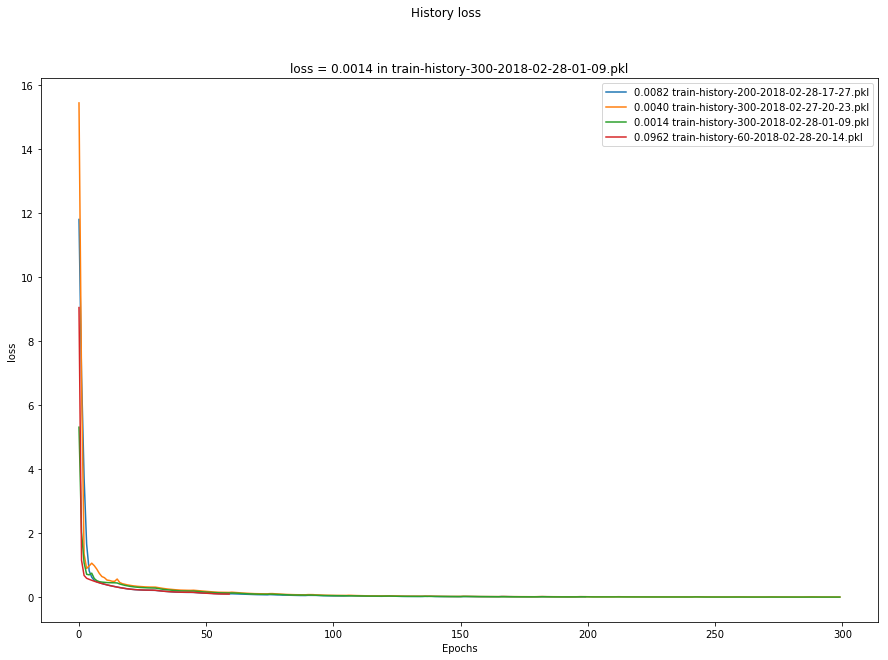

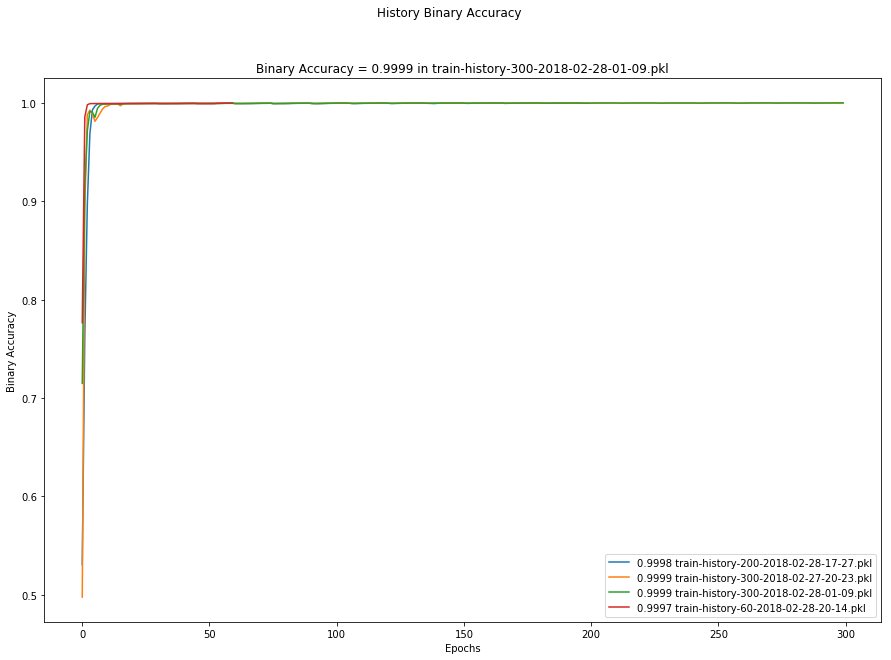

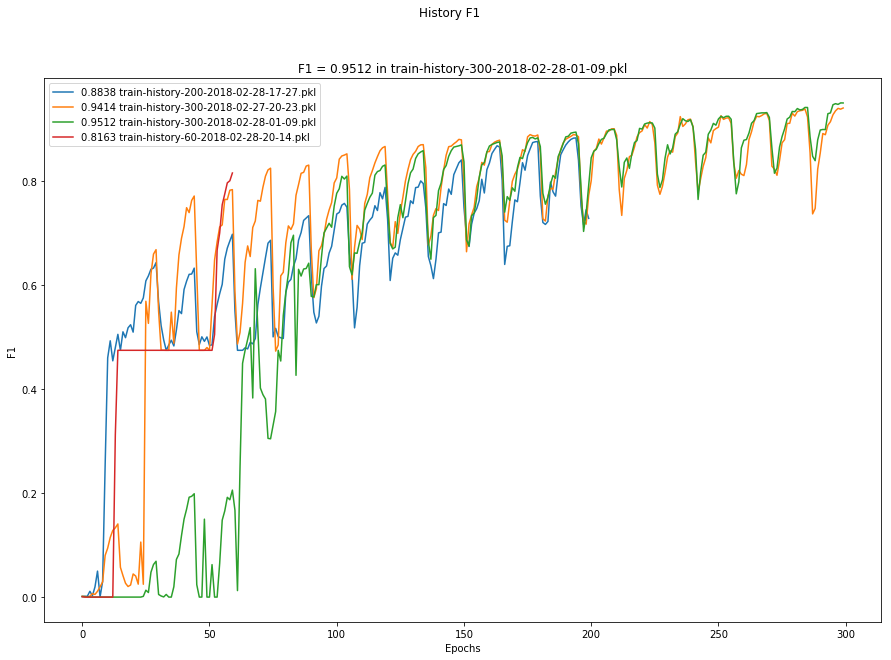

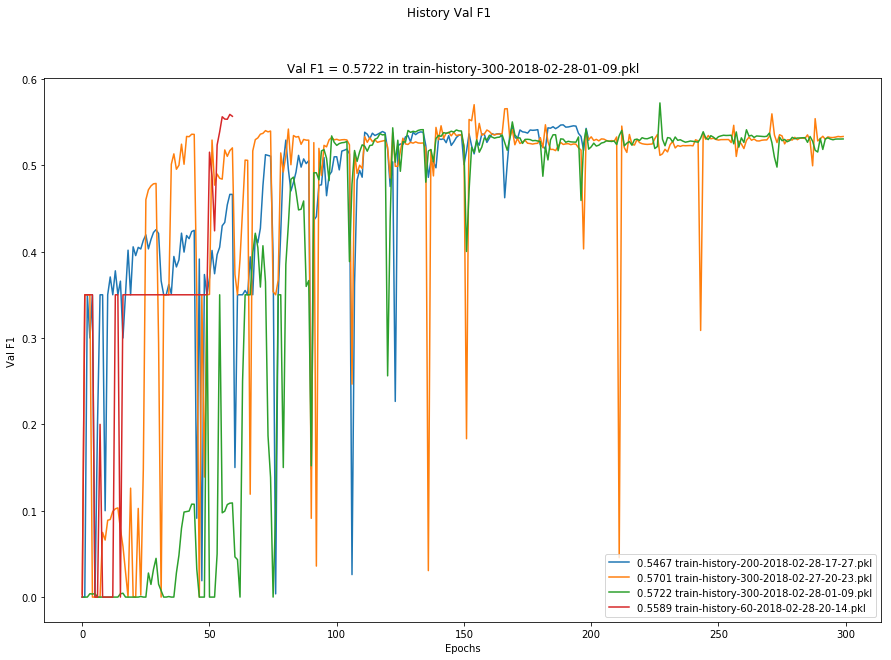

In [1026]:
if 1 :
    import pickle
    listHistory = os.listdir(os.path.join('../Temp','History'))

    def drawHistory (name, index, minOK=False) :

        plt.figure(figsize=(15,10))
        legend, ffmmm, ffvvv = [], '', 100 if minOK else -1
        try :
            for ff in listHistory :
                with open(os.path.join('../Temp',"History",ff),"rb") as fp: fh = pickle.load(fp);
                fhh = np.array(fh[index])
                plt.plot(fhh); legend += ["{:.4f} {}".format((fhh.min() if minOK else fhh.max()),ff)]
                if minOK : 
                    if fhh.min()<ffvvv : ffvvv = fhh.min(); ffmmm = ff
                else :
                    if fhh.max()>ffvvv : ffvvv = fhh.max(); ffmmm = ff
            plt.suptitle('History '+name)
            plt.title(name + ' = {:.4f} in {}'.format(ffvvv,ffmmm))
            plt.xlabel('Epochs')
            plt.ylabel(name)
            plt.legend(legend);
            plt.show()
        except : pass;

    drawHistory('LR','lr',minOK=True)
    drawHistory('loss','loss',minOK=True)
    drawHistory('Binary Accuracy','binary_accuracy',minOK=False)
    drawHistory('F1','f1scoreTF',minOK=False)
    drawHistory('Val F1','val_f1scoreTF',minOK=False)

    plt.close('all')

In [966]:
if 1 :
    filemodel = '../Temp/V02-6-level-X-val_f1scoreTF=0.6127-(0.7739).hdf5'
    filemodel = '../Temp/V02-6-level-1-val_f1scoreTF=0.7315-(0.9092).hdf5' 
    filemodel = '../Temp/V02-6-level-1-val_f1scoreTF=0.7322-(0.8746).hdf5' 
    filemodel = '../Temp/V02-6-level-1-val_f1scoreTF=0.7314-(0.8880).hdf5' 
    filemodel = '../Temp/V02-6-level-X-val_f1scoreTF=0.6201-(0.8606).hdf5'  

    filemodel = '../Temp/V02-6-level-X-val_f1scoreTF=0.6402-(0.7912).hdf5'
    filemodel = '../Temp/V02-6-level-1-val_f1scoreTF=0.9982-(0.9980).hdf5'
    
    filemodel = '../Temp/V02-6-level-1-val_f1scoreTF=0.1224-(0.1490).hdf5'
    filemodel = '../Temp/V02-6-level-1-val_f1scoreTF=0.4748-(0.5808).hdf5'
    
    
    filemodel = '../Temp/V02-6-level-1-val_f1scoreTF=0.5706-(0.7676).hdf5'
    
    filemodel = '../Temp/V02-6-level-1-val_f1scoreTF=0.5722-(0.7883).hdf5'
    
    #model10 = modelLoad(filemodel)
    PP      = modelPredict(model10, XX, batch_size=batch_size)
if 1 :
    print(datetime.datetime.now())
    ev = model10.evaluate(x=XX[path1:path2], y=YY[path1:path2], batch_size=batch_size, verbose=0)
    print(ev)
    ev = model10.evaluate(x=XX, y=YY, batch_size=batch_size, verbose=0)
    print(ev)

2018-02-28 17:36:39.634630
[0.016759766216855498, 0.99942134916782377, 0.66280984356999395]
[0.060109084825517356, 0.99774835546145768, 0.46215449370115746]


In [645]:
if 1 :
    filemodel = '../Temp/V02-6-level-X-val_f1scoreTF=0.6127-(0.7739).hdf5'
    filemodel = '../Temp/V02-6-level-1-val_f1scoreTF=0.7315-(0.9092).hdf5' 
    filemodel = '../Temp/V02-6-level-1-val_f1scoreTF=0.7322-(0.8746).hdf5' 
    filemodel = '../Temp/V02-6-level-1-val_f1scoreTF=0.7314-(0.8880).hdf5' 
    filemodel = '../Temp/V02-6-level-X-val_f1scoreTF=0.6201-(0.8606).hdf5'  

    filemodel = '../Temp/V02-6-level-X-val_f1scoreTF=0.6402-(0.7912).hdf5'
    filemodel = '../Temp/V02-6-level-1-val_f1scoreTF=0.9982-(0.9980).hdf5'
    
    filemodel = '../Temp/V02-6-level-1-val_f1scoreTF=0.1224-(0.1490).hdf5'
    filemodel = '../Temp/V02-6-level-1-val_f1scoreTF=0.4748-(0.5808).hdf5'
    filemodel = '../Temp/V02-6-level-1-val_f1scoreTF=0.5266-(0.6856).hdf5'
    
    filemodel = '../Temp/V02-6-level-1-val_f1scoreTF=0.5701-(0.7502).hdf5'

    model10 = modelLoad(filemodel)
    PP      = modelPredict(model10, XX, batch_size=batch_size)
if 1 :
    print(datetime.datetime.now())
    ev = model10.evaluate(x=XX[path1:path2], y=YY[path1:path2], batch_size=batch_size, verbose=0)
    print(ev)
    ev = model10.evaluate(x=XX, y=YY, batch_size=batch_size, verbose=0)
    print(ev)

2018-02-27 20:35:59.771727
[0.029235907783731818, 0.99923139512538905, 0.67262000650167464]
[0.076637397416462361, 0.99733911856600133, 0.47313045771458828]


(4119, 416, 416, 1)


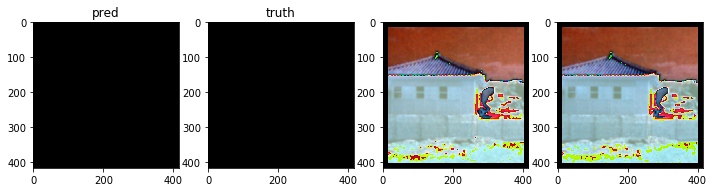

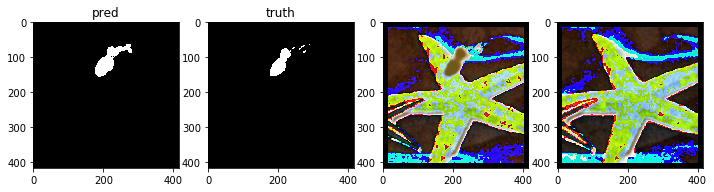

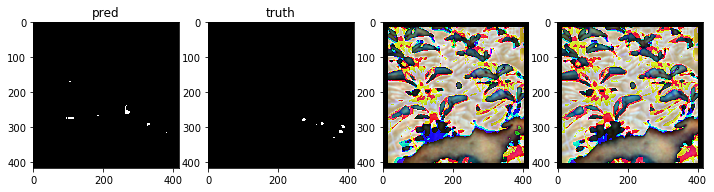

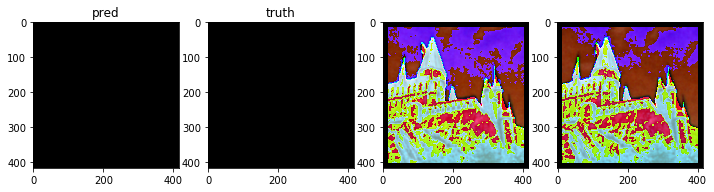

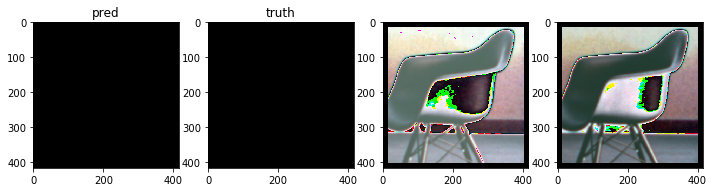

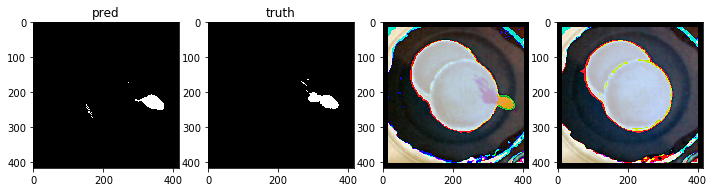

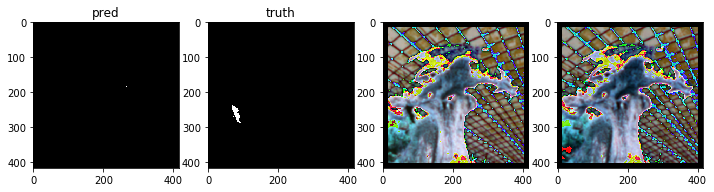

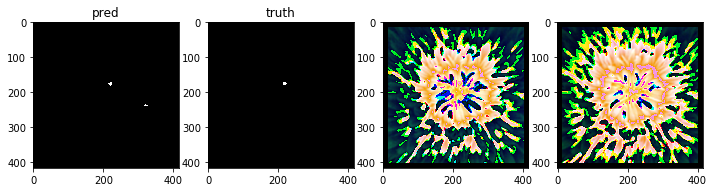

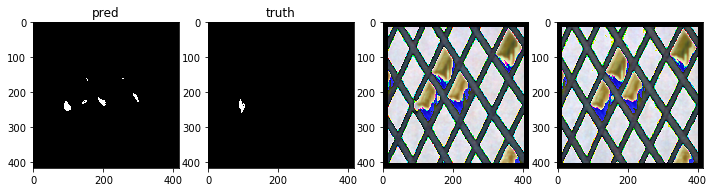

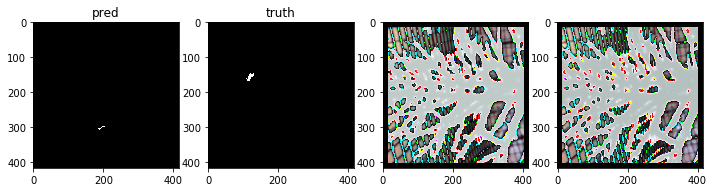

In [71]:
LL = range(3700,3710)
th = 0.5
print(PP.shape)
for NN in LL :
    plt.figure(figsize=(12,5))
    ppp = PP[NN].reshape(PP.shape[1:-1]).copy(); ppp[ppp>=th] = 1.0; ppp[ppp<th] = 0.0; 
    plt.subplot(1,4,1);  plt.imshow(ppp,'gray'); plt.title('pred')
    plt.subplot(1,4,2);  plt.imshow(YY[NN].reshape(YY.shape[1:-1]),'gray');  plt.title('truth')
    plt.subplot(1,4,3);  plt.imshow(X1[NN]);
    plt.subplot(1,4,4);  plt.imshow(X2[NN]);
    plt.show()

In [26]:
plt.close()

17.983333333333334

In [497]:
'''
print(K.get_value(f1scoreTF(YY[:4],PP[:4],th=None,printOK=True)))
print(K.get_value(f1scoreTF(YY[:4],PP[:4],th=0.1)))
print(K.get_value(f1scoreTF(YY[:4],PP[:4],th=0.5)))
print(K.get_value(f1scoreTF(YY[:4],PP[:4],th=0.8)))
print(K.get_value(f1scoreTF(YY[:4],PP[:4],th=0.9999,printOK=True)))
'''
tYY = K.variable(YY[:14])
tPP = K.variable(PP[:14])
print(K.get_value(K.mean(lossXf1(tYY,tPP),axis=(1,2))))
print(K.get_value(K.mean(keras.losses.binary_crossentropy(tYY,tPP),axis=(1,2))))

[ -3.73799419e+00  -6.86845660e-01  -3.87168646e-01  -5.70928633e-01
  -7.94541979e+00  -1.62381971e+00  -4.79906619e-01  -4.44859803e-01
  -9.23750496e+00   8.11254140e-03  -4.63137329e-01  -4.51516037e+01
   6.23761900e-02  -3.89903307e+00]
[ -3.11800957e+00   1.82744360e-03   2.38380581e-01   8.86177719e-02
  -7.32644749e+00  -9.92239833e-01   1.52948231e-01   1.75346300e-01
  -8.62314320e+00   5.75728536e-01   1.52001888e-01  -4.45593147e+01
   6.51660919e-01  -3.30966520e+00]


In [31]:
if 0 :
    
    filepath = '../Temp/V02-level-1-val_f1scoreTF=0.6886-(0.6856).hdf5'  # level 1
    filepath = '../Temp/V02-level-2-val_f1scoreTF=0.5335-(0.6606).hdf5'  # level 2
    filepath = '../Temp/V02-level-3-val_f1scoreTF=0.5343-(0.5744).hdf5'  # level 3
    
    K.clear_session()
    
    model10 = mergeXX((416,416,3))
    model10.load_weights(filepath, by_name=True) 
    model10.compile(loss=lossZf1, #'binary_crossentropy',
              optimizer='adam', #sgd, #"adam", #'rmsprop',
              metrics=['binary_accuracy',f1scoreTF]) 
    
if 1 :
    print(datetime.datetime.now())
    PP = model10.predict([X1,X2],batch_size=batch_size)
    print(datetime.datetime.now())    

2018-02-16 18:51:29.606887
2018-02-16 18:53:52.321560


In [25]:
from keras.models import load_model

def modelLoad (filemodel) :
    model10 = load_model(filemodel,compile=True,custom_objects={'lossZf1': lossZf1,'f1scoreTF': f1scoreTF})
    return(model10)

def modelPredict (model, XX, batch_size=18) :
    PP = model.predict(XX,batch_size=batch_size)
    return(PP)

def modelLoadAndPredict (filepath, XX, batch_size=18) :
    model10 = modelLoad(filepath)
    PP      = model10.predict(XX,batch_size=batch_size)
    return(PP)

In [82]:
if 0 :
    filemodel='../Temp/V02-6-level-X-val_f1scoreTF=0.6127-(0.7739).hdf5'
    #xmodel = modelLoad(filemodel)
    from keras.models import load_model
    xmodel = load_model(filemodel,compile=True,custom_objects={'lossZf1': lossZf1,'f1scoreTF': f1scoreTF})

In [83]:
def saveResult(dirPath, PP, fileList, th=0.5) :
    
    print(PP.shape,NN.shape)
    
    for ii,fn in enumerate(fileList) :
        
        #if ii>5 : break;
        
        #print(ii,fn,dirPath,fn+'_mask.txt')
        pp = np.array(PP[ii]); 
        #print(pp.shape, PP.shape,NN.shape)
        pp[pp<=th]=0; 
        pp[pp>=th]=1; 
        pp=np.array(pp,dtype=np.int8)
        
        DIMENSION = 390
        out = open(os.path.join(dirPath,fn+'_mask.txt'),'w');
        for x in xrange(DIMENSION):
            for y in xrange(DIMENSION):
                out.write(str(int(pp[13+y, 13+x])))
            out.write('\n')
        out.close()        
        
        if ii%500==0 : print(datetime.datetime.now(), '\t', ii,'/',len(fileList), fn)
            
    return
        

In [84]:
##saveResult(dirForResult,PP,NN,0.5)

In [85]:
def clearDirectory(dirPath) :
    import shutil
    shutil.rmtree(dirPath)
    return

In [86]:
del XX,NN

In [88]:
# Build decision
# Train datas

print(datetime.datetime.now(), 'Begin')


dirForResult = '../Result/Temp'

# 2018-02-23
filemodel = '../Temp/V02-6-level-X-val_f1scoreTF=0.6127-(0.7739).hdf5'
filemodel = '../Temp/V02-6-level-X-val_f1scoreTF=0.5958-(0.7999).hdf5'
filemodel = '../Temp/V02-6-level-X-val_f1scoreTF=0.6201-(0.8606).hdf5'

filemodel = '../Temp/V02-6-level-X-val_f1scoreTF=0.6402-(0.7912).hdf5'

ths = 0.5

clearDirectory(dirForResult)
if not os.path.exists(dirForResult) : os.makedirs(dirForResult)

##########if 0 :
print(datetime.datetime.now(), 'Train')

# 2018-02-23

NN = np.load(os.path.join(dirForSave,'train-NN-S6.npy'))
XX = np.load(os.path.join(dirForSave,'train-XX-S6.npy'))

PP     = modelLoadAndPredict(filemodel, XX, batch_size=batch_size)
saveResult(dirForResult,PP,NN,ths)

del NN,XX,PP
# Dev datas

# 2018-02-23

NN = np.load(os.path.join(dirForSave,'dev-NN-S6.npy'))
XX = np.load(os.path.join(dirForSave,'dev-XX-S6.npy'))

PP     = modelLoadAndPredict(filemodel, XX, batch_size=batch_size)
saveResult(dirForResult,PP,NN,ths)

del NN,XX,PP

# Test/PlaceHolder 

# 2018-02-23

NN = np.load(os.path.join(dirForSave,'test-NN-S6.npy'))
XX = np.load(os.path.join(dirForSave,'test-XX-S6.npy'))

PP     = modelLoadAndPredict(filemodel, XX, batch_size=batch_size)
saveResult(dirForResult,PP,NN,ths)

print(datetime.datetime.now(), 'End')
    

2018-02-25 13:07:39.570437 Begin
2018-02-25 13:07:43.846021 Train
(4119, 416, 416, 1) (4119,)
2018-02-25 13:15:25.405644 	 0 / 4119 1014
2018-02-25 13:17:00.315739 	 500 / 4119 577
2018-02-25 13:17:58.784462 	 1000 / 4119 4393
2018-02-25 13:18:49.186619 	 1500 / 4119 6271
2018-02-25 13:19:37.793233 	 2000 / 4119 3582
2018-02-25 13:20:28.083507 	 2500 / 4119 2394
2018-02-25 13:21:22.512717 	 3000 / 4119 2727
2018-02-25 13:22:11.176528 	 3500 / 4119 2581
2018-02-25 13:23:00.203805 	 4000 / 4119 4701
(1405, 416, 416, 1) (1405,)
2018-02-25 13:26:36.735335 	 0 / 1405 1033
2018-02-25 13:27:50.786285 	 500 / 1405 1639
2018-02-25 13:28:42.652922 	 1000 / 1405 6279
(1358, 416, 416, 1) (1358,)
2018-02-25 13:32:18.113446 	 0 / 1358 1002
2018-02-25 13:33:21.018163 	 500 / 1358 2735
2018-02-25 13:34:19.345332 	 1000 / 1358 2773
2018-02-25 13:34:57.742608 End


In [55]:
3004/4+5980/4+7492/4+490/2+1020/2+1300/2

5524

In [89]:
# write in zip file
import zipfile
try:
    import zlib
    compression = zipfile.ZIP_DEFLATED
except:
    compression = zipfile.ZIP_STORED

modes = { zipfile.ZIP_DEFLATED: 'deflated',
          zipfile.ZIP_STORED:   'stored',
          }

print ('creating archive')
zf = zipfile.ZipFile('../Result/KM2018.zip', mode='w')
try:
    print ('adding with compression mode', modes[compression])
    for fn in os.listdir(dirForResult) :
        #zf.write('../Result/bobaUrban3D.txt', arcname='bobaUrban3D.txt', compress_type=compression)
        if fn.startswith('.') : continue
        zf.write(os.path.join('../Result/Temp',fn), arcname=fn, compress_type=compression)
finally:
    print ('closing')
    zf.close()
print(datetime.datetime.now())

creating archive
adding with compression mode deflated
closing
2018-02-25 13:36:53.502658


In [33]:
try :
    del NN,XX,YY
except : a = 0
finally :
    #NN = np.load(os.path.join(dirForSave,'train-NN-S6.npy'))
    #XX = np.load(os.path.join(dirForSave,'train-XX-S6.npy'))
    #YY = np.load(os.path.join(dirForSave,'train-YY-S6.npy'))
    
    #NN = np.load(os.path.join(dirForSave,'test-NN-S6.npy'))
    #XX = np.load(os.path.join(dirForSave,'test-XX-S6.npy'))
    
    PP     = modelLoadAndPredict(filemodel, XX, batch_size=batch_size)

In [51]:
np.where(NN=='331')


(array([], dtype=int64),)

In [1027]:
if 0 :
    PP  = modelPredict(model10,XX,batch_size=batch_size)

(10, 416, 416) (10, 416, 416) 0.0043157 2.66624 0.0 1.0
[[ 1.09118474  0.66821349  0.00122545]
 [ 1.09147501  1.         -0.        ]
 [ 1.09128594  1.         -0.        ]
 [ 1.09119725  1.         -0.        ]
 [ 1.09173119  0.79286689  0.00137668]
 [ 1.09128308  0.40723979  0.00112484]
 [ 1.09140706  1.         -0.        ]
 [ 1.09107447  1.         -0.        ]
 [ 1.09170592  0.75519997  0.001431  ]
 [ 1.09122074  1.         -0.        ]]
[[ 0.09241     0.01579     1.09117997  0.66821003  0.99878001]
 [ 0.09147     0.          1.09148002  1.          1.        ]
 [ 0.09129     0.          1.09129     1.          1.        ]
 [ 0.0912      0.          1.09119999  1.          1.        ]
 [ 0.09311     0.01648     1.09173     0.79286999  0.99861997]
 [ 0.09241     0.0163      1.09127998  0.40724     0.99888003]
 [ 0.09141     0.          1.09141004  1.          1.        ]
 [ 0.09107     0.          1.09107006  1.          1.        ]
 [ 0.09314     0.01877     1.09170997  0.75520003

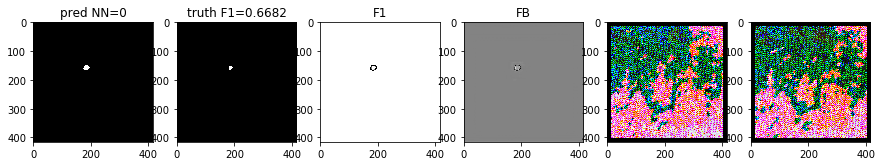

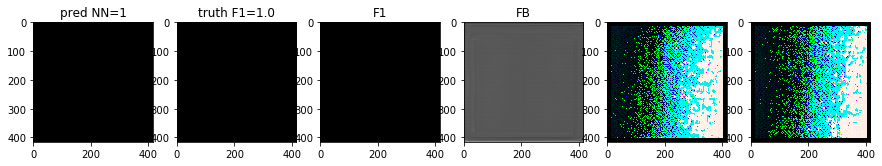

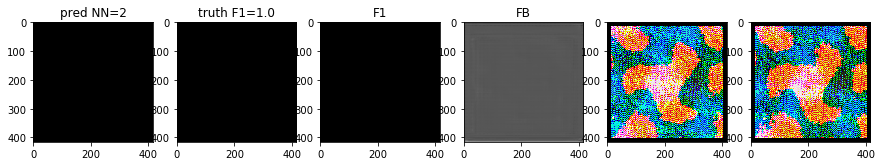

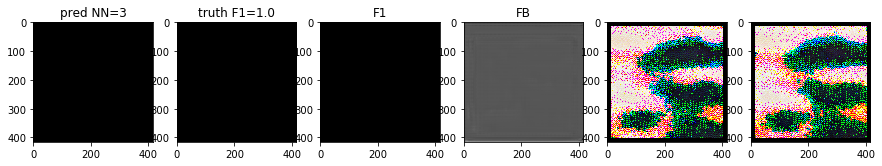

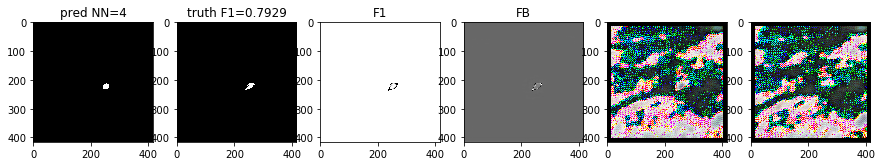

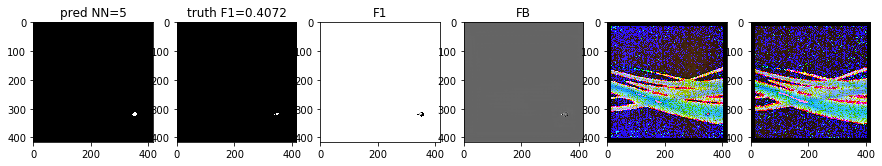

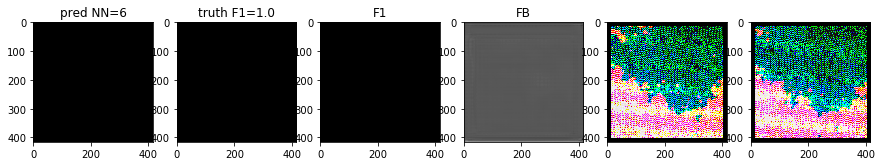

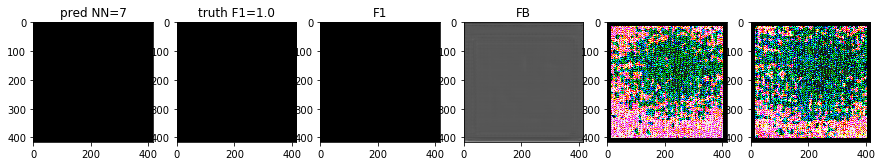

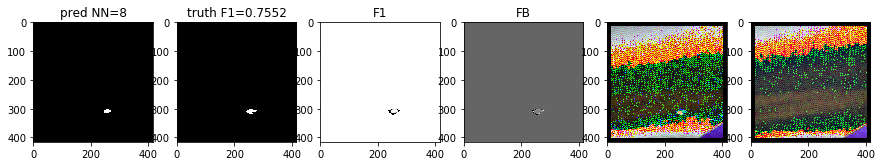

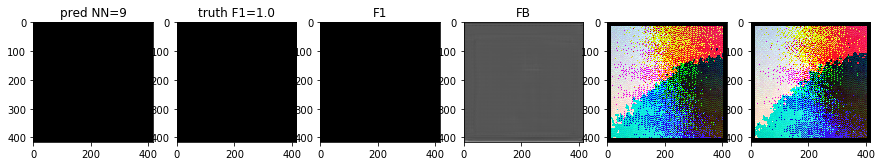

In [1028]:
LL = range(0,10)
YYY= K.variable(YY[LL])
PPP= K.variable(PP[LL])

F1  = K.eval(K.clip(F1ScorePP(YYY,PPP,th=0.5,kernel=3),K.epsilon(),1.0))
F1L = K.eval(-K.log(K.clip(F1ScorePP(YYY,PPP,th=0.5),K.epsilon(),1.0)))
F11 = K.eval(F1ScoreCC(YYY,PPP,th=0.5))

F12 = [xx.mean() for xx in F1]

BCE = K.eval(keras.losses.binary_crossentropy(YYY,PPP))
FB  = F1+BCE

print(F1.shape, BCE.shape, BCE.min(), BCE.max(), YY[LL].min(), YY[LL].max())

print(np.array([FB.mean(axis=(1,2)),F11,-np.log(F12)]).T)

if 1 :

    print(np.round(np.array([BCE.mean(axis=(1,2)),F1L.mean(axis=(1,2)),FB.mean(axis=(1,2)),F11,F12]).T,5))

    print(np.array([BCE.min(axis=(1,2)),F1L.min(axis=(1,2)),FB.min(axis=(1,2)),F11]).T)

    print(np.array([BCE.max(axis=(1,2)),F1L.max(axis=(1,2)),FB.max(axis=(1,2)),F11]).T)

#print(BCE.mean(axis=(1,2)))
#print( F1.mean(axis=(1,2)))
#print(F11)
#print( FB.mean(axis=(1,2)))
#print(YY[LL].mean(axis=(1,2)))
#print(PP[LL].mean(axis=(1,2)))
th = 0.5
print(PP.shape)
#plt.figure(figsize=(15,10)); plt.scatter(FB.mean(axis=(1,2)),F11), plt.show()
    
for NN in LL :
    plt.figure(figsize=(15,10))
    ppp = PP[NN].reshape(PP.shape[1:-1]).copy(); ppp[ppp>=th] = 1.0; ppp[ppp<th] = 0.0; 
    plt.subplot(1,6,1);  plt.imshow(ppp,'gray'); 
    plt.title('pred NN='+str(NN))
    plt.subplot(1,6,2);  plt.imshow(YY[NN].reshape(YY.shape[1:-1]),'gray');  
    plt.title('truth F1='+str(round(F11[NN],4)))
    
    plt.subplot(1,6,3);  plt.imshow(F1[NN,:,:],'gray');   plt.title('F1')
    #plt.subplot(1,6,4);  plt.imshow(BCE[NN,:,:],'gray');  plt.title('BCE')
    plt.subplot(1,6,4);  plt.imshow(FB[NN,:,:],'gray');  plt.title('FB')
    
    #plt.subplot(1,6,4);  plt.hist(F1[NN][F1[NN]>0].ravel());
    #plt.subplot(1,6,4);  plt.hist(BCE[NN][BCE[NN]>0].ravel());
    
    plt.subplot(1,6,5);  plt.imshow(XX[NN,:,:,0:3]);
    plt.subplot(1,6,6);  plt.imshow(XX[NN,:,:,3:6]);
    plt.show()
    
    if 0 :
        plt.figure(figsize=(15,10))
        plt.imshow(ppp,'gray'); plt.title('pred')
        plt.figure(figsize=(15,10))
        plt.imshow(XX[NN,:,:,0:3]); plt.show()
        plt.figure(figsize=(15,10))
        plt.imshow(XX[NN,:,:,3:6]); plt.show()


In [799]:
cv2.getGaussianKernel(3,-1)*cv2.getGaussianKernel(3,-1).T

array([[ 0.0625,  0.125 ,  0.0625],
       [ 0.125 ,  0.25  ,  0.125 ],
       [ 0.0625,  0.125 ,  0.0625]])

In [795]:
K.eval(K.random_normal((5,5)))

array([[-0.87304991, -2.6148293 ,  0.92441684, -0.18850131,  2.03971696],
       [ 1.36011481, -0.76584381, -0.33120269,  1.04722166, -1.75972283],
       [-0.55993152, -0.35699067, -0.30392429,  0.39571804,  1.78401983],
       [ 0.17627323, -1.39003325,  0.12372831, -1.0974983 ,  1.29404092],
       [-0.78407413, -0.20269799, -0.42254665,  0.2508485 , -0.17186181]], dtype=float32)

In [797]:
from scipy.stats import multivariate_normal
y = multivariate_normal.pdf(x, mean=2.5, cov=0.5); y

In [911]:
K.eval(K.mean(lossZf1(K.variable(YY[900:1000]),K.variable(PP[900:1000])),axis=(1,2)))

array([  9.90531072e-02,   1.66868623e-02,   1.25281647e-01,
         6.06827845e-04,   8.91512930e-02,   8.48142244e-03,
         5.31125665e-02,   8.92186351e-03,   5.95493766e-04,
         5.84273674e-02,   3.02946866e-02,   6.36637094e-04,
         5.36833424e-03,   1.51980920e-02,   6.14946038e-02,
         5.96804428e-04,   1.36418436e-02,   3.50649863e-01,
         8.25737342e-02,   1.28803998e-02,   1.90950066e-01,
         8.48250277e-03,   5.72123611e-03,   6.04750996e-04,
         8.16964824e-03,   1.21052312e-02,   1.49197038e-02,
         3.17509612e-03,   1.65859405e-02,   5.95016812e-04,
         1.73002183e-02,   9.62574407e-03,   6.03178807e-04,
         1.96057960e-01,   6.10305404e-04,   9.44607779e-02,
         6.01355510e-04,   6.22441410e-04,   5.95148478e-04,
         5.68321999e-03,   7.21250102e-03,   4.14270423e-02,
         6.67568878e-04,   6.01167092e-04,   1.82562191e-02,
         1.76626444e-02,   1.18515007e-02,   2.67491434e-02,
         2.70862896e-02,